# Task 3: A/B Hypothesis Testing

## Hypotheses to test:
1. There are no risk differences across provinces
2. There are no risk differences between zipcodes
3. There is no significant margin (profit) difference between zip codes
4. There is no significant risk difference between Women and men

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load the data (use df_valid from previous analysis or reload)
# Let's reload to be sure we have clean data
df = pd.read_csv('../data/raw/insurance_data.txt', delimiter='|', low_memory=False)

# Convert key columns
df['TotalPremium'] = pd.to_numeric(df['TotalPremium'], errors='coerce')
df['TotalClaims'] = pd.to_numeric(df['TotalClaims'], errors='coerce')
df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'], errors='coerce')

# Filter out zero premiums for accurate analysis
df_valid = df[df['TotalPremium'] > 0].copy()
df_valid['LossRatio'] = df_valid['TotalClaims'] / df_valid['TotalPremium']

print(f"Data loaded. Shape: {df_valid.shape}")
print(f"Valid policies (premium > 0): {len(df_valid):,}")

Data loaded. Shape: (618176, 53)
Valid policies (premium > 0): 618,176


In [3]:
# Cell 3: Hypothesis Test 1 - Risk differences across provinces
print("=" * 60)
print("HYPOTHESIS TEST 1: Risk differences across provinces")
print("=" * 60)
print("Null Hypothesis: There are no risk differences across provinces")
print("Alternative Hypothesis: There ARE risk differences across provinces")
print()

# Check provinces in data
print("Provinces in dataset:")
print(df_valid['Province'].value_counts())
print()

# We'll use ANOVA test to compare means across provinces
# First, check assumptions
print("Checking ANOVA assumptions...")

# 1. Normality - Shapiro-Wilk test on sample from each province
print("1. Normality check (Shapiro-Wilk on samples):")
for province in df_valid['Province'].unique():
    sample = df_valid[df_valid['Province'] == province]['LossRatio'].dropna().sample(min(5000, len(df_valid[df_valid['Province'] == province])), random_state=42)
    stat, p = stats.shapiro(sample)
    print(f"   {province:20} p-value: {p:.4f} {'(Normal)' if p > 0.05 else '(Not Normal)'}")
print()

# 2. Homogeneity of variances - Levene's test
print("2. Homogeneity of variances (Levene's test):")
levene_stat, levene_p = stats.levene(*[df_valid[df_valid['Province'] == province]['LossRatio'].dropna() 
                                       for province in df_valid['Province'].unique()])
print(f"   Levene's test p-value: {levene_p:.4f}")
print(f"   {'Variances are equal' if levene_p > 0.05 else 'Variances are NOT equal'}")
print()

# 3. Perform ANOVA (even if assumptions violated - we'll interpret cautiously)
print("3. One-way ANOVA results:")
anova_result = stats.f_oneway(*[df_valid[df_valid['Province'] == province]['LossRatio'].dropna() 
                                for province in df_valid['Province'].unique()])
print(f"   F-statistic: {anova_result.statistic:.4f}")
print(f"   p-value: {anova_result.pvalue:.4f}")
print()

# 4. Interpretation
print("4. CONCLUSION:")
if anova_result.pvalue < 0.05:
    print("   REJECT the null hypothesis.")
    print("   There IS statistically significant evidence of risk differences across provinces.")
    print("   Provinces have different loss ratios (risk levels).")
else:
    print("   FAIL TO REJECT the null hypothesis.")
    print("   There is NOT enough evidence to say provinces have different risk levels.")
print()

# 5. Effect size (eta-squared) to measure practical significance
print("5. Effect size (how big is the difference?):")
# Calculate eta-squared
ss_between = sum([len(df_valid[df_valid['Province'] == province]) * 
                  (df_valid[df_valid['Province'] == province]['LossRatio'].mean() - df_valid['LossRatio'].mean())**2 
                  for province in df_valid['Province'].unique()])
ss_total = sum((df_valid['LossRatio'] - df_valid['LossRatio'].mean())**2)
eta_squared = ss_between / ss_total
print(f"   Eta-squared: {eta_squared:.4f}")
print(f"   Interpretation: {'Large effect' if eta_squared > 0.14 else 'Medium effect' if eta_squared > 0.06 else 'Small effect'}")

HYPOTHESIS TEST 1: Risk differences across provinces
Null Hypothesis: There are no risk differences across provinces
Alternative Hypothesis: There ARE risk differences across provinces

Provinces in dataset:
Province
Gauteng          240782
KwaZulu-Natal    111896
Western Cape      96758
North West        89799
Mpumalanga        31663
Eastern Cape      19694
Limpopo           18009
Free State         5932
Northern Cape      3643
Name: count, dtype: int64

Checking ANOVA assumptions...
1. Normality check (Shapiro-Wilk on samples):
   Gauteng              p-value: 0.0000 (Not Normal)
   KwaZulu-Natal        p-value: 0.0000 (Not Normal)
   Mpumalanga           p-value: 0.0000 (Not Normal)
   Eastern Cape         p-value: 0.0000 (Not Normal)
   Western Cape         p-value: 0.0000 (Not Normal)
   Limpopo              p-value: 0.0000 (Not Normal)
   North West           p-value: 0.0000 (Not Normal)
   Free State           p-value: 0.0000 (Not Normal)
   Northern Cape        p-value: 0.0000 

In [4]:
# Cell 4: Non-parametric test for province differences (Kruskal-Wallis)
print("=" * 60)
print("NON-PARAMETRIC TEST: Kruskal-Wallis (since data not normal)")
print("=" * 60)

# Perform Kruskal-Wallis test
kw_stat, kw_p = stats.kruskal(*[df_valid[df_valid['Province'] == province]['LossRatio'].dropna() 
                                for province in df_valid['Province'].unique()])

print(f"Kruskal-Wallis H-statistic: {kw_stat:.4f}")
print(f"p-value: {kw_p:.4f}")
print()

# Interpretation
if kw_p < 0.05:
    print("REJECT the null hypothesis (using non-parametric test).")
    print("Conclusion: There ARE statistically significant risk differences across provinces.")
    
    # Post-hoc test to see which provinces are different
    print("\nPost-hoc Dunn's test (which provinces are different?):")
    
    # We'll do a simple comparison: compare each province to the overall median
    overall_median = df_valid['LossRatio'].median()
    print(f"Overall median Loss Ratio: {overall_median:.4f}")
    print("\nProvinces significantly different from overall median:")
    
    for province in df_valid['Province'].unique():
        province_data = df_valid[df_valid['Province'] == province]['LossRatio'].dropna()
        province_median = province_data.median()
        
        # Mann-Whitney U test for each province vs all others
        other_data = df_valid[df_valid['Province'] != province]['LossRatio'].dropna()
        u_stat, u_p = stats.mannwhitneyu(province_data, other_data, alternative='two-sided')
        
        if u_p < 0.05:
            diff = province_median - overall_median
            direction = "HIGHER" if diff > 0 else "LOWER"
            print(f"  • {province:20} Median: {province_median:.4f} ({direction} risk, p={u_p:.4f})")
else:
    print("FAIL TO REJECT the null hypothesis.")
    print("Conclusion: No significant risk differences across provinces.")

NON-PARAMETRIC TEST: Kruskal-Wallis (since data not normal)
Kruskal-Wallis H-statistic: 93.5554
p-value: 0.0000

REJECT the null hypothesis (using non-parametric test).
Conclusion: There ARE statistically significant risk differences across provinces.

Post-hoc Dunn's test (which provinces are different?):
Overall median Loss Ratio: 0.0000

Provinces significantly different from overall median:
  • Gauteng              Median: 0.0000 (LOWER risk, p=0.0000)
  • Eastern Cape         Median: 0.0000 (LOWER risk, p=0.0000)
  • Western Cape         Median: 0.0000 (LOWER risk, p=0.0018)
  • North West           Median: 0.0000 (LOWER risk, p=0.0063)
  • Free State           Median: 0.0000 (LOWER risk, p=0.0011)


VISUALIZATION: Province Risk Differences


/var/folders/yy/4gyb_b194zj9hml4grr4vbjm0000gn/T/ipykernel_9481/1449154381.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax1.boxplot(box_data, labels=province_order, patch_artist=True)


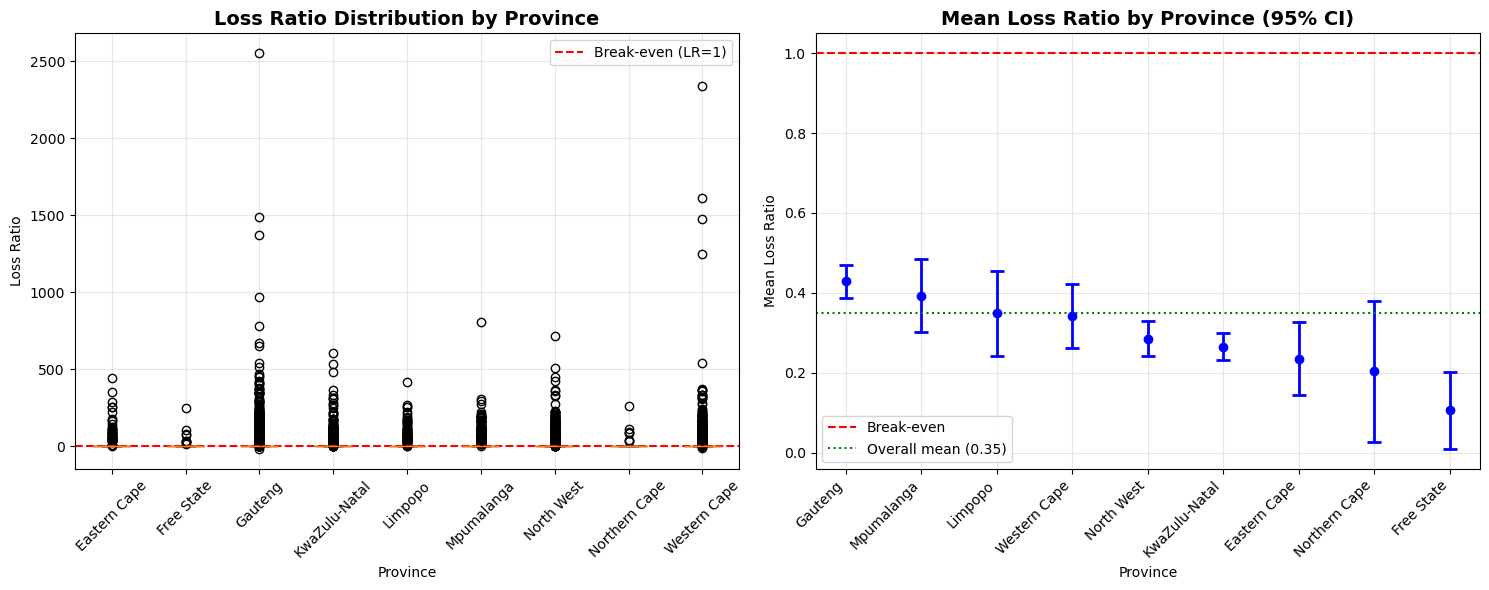

Visualization saved to: reports/hypothesis_test1_provinces.png


In [5]:
print("=" * 60)
print("VISUALIZATION: Province Risk Differences")
print("=" * 60)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Box plot of Loss Ratio by Province
province_order = df_valid.groupby('Province')['LossRatio'].median().sort_values(ascending=False).index

box_data = [df_valid[df_valid['Province'] == province]['LossRatio'].dropna() 
            for province in province_order]

box = ax1.boxplot(box_data, labels=province_order, patch_artist=True)
ax1.set_title('Loss Ratio Distribution by Province', fontsize=14, fontweight='bold')
ax1.set_xlabel('Province')
ax1.set_ylabel('Loss Ratio')
ax1.axhline(y=1, color='red', linestyle='--', label='Break-even (LR=1)')
ax1.tick_params(axis='x', rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Color boxes based on median
colors = []
for i, province in enumerate(province_order):
    median_lr = df_valid[df_valid['Province'] == province]['LossRatio'].median()
    if median_lr > 1:
        colors.append('lightcoral')  # High risk
    elif median_lr > 0.7:
        colors.append('lightyellow')  # Medium risk
    else:
        colors.append('lightgreen')  # Low risk

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Plot 2: Mean Loss Ratio with confidence intervals
province_stats = df_valid.groupby('Province').agg({
    'LossRatio': ['mean', 'count', 'std']
}).round(4)

province_stats.columns = ['mean', 'count', 'std']
province_stats = province_stats.sort_values('mean', ascending=False)

# Calculate 95% confidence intervals
province_stats['ci_lower'] = province_stats['mean'] - 1.96 * province_stats['std'] / np.sqrt(province_stats['count'])
province_stats['ci_upper'] = province_stats['mean'] + 1.96 * province_stats['std'] / np.sqrt(province_stats['count'])

x_pos = range(len(province_stats))
ax2.errorbar(x_pos, province_stats['mean'], 
             yerr=[province_stats['mean'] - province_stats['ci_lower'], 
                   province_stats['ci_upper'] - province_stats['mean']],
             fmt='o', capsize=5, capthick=2, elinewidth=2, color='blue')

ax2.set_xticks(x_pos)
ax2.set_xticklabels(province_stats.index, rotation=45, ha='right')
ax2.set_title('Mean Loss Ratio by Province (95% CI)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Province')
ax2.set_ylabel('Mean Loss Ratio')
ax2.axhline(y=1, color='red', linestyle='--', label='Break-even')
ax2.axhline(y=df_valid['LossRatio'].mean(), color='green', linestyle=':', 
            label=f'Overall mean ({df_valid["LossRatio"].mean():.2f})')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/hypothesis_test1_provinces.png', dpi=150, bbox_inches='tight')
plt.show()

print("Visualization saved to: reports/hypothesis_test1_provinces.png")

In [6]:
print("=" * 60)
print("INVESTIGATING CLAIMS DISTRIBUTION")
print("=" * 60)

# Check how many policies have claims
zero_claims = (df_valid['TotalClaims'] == 0).sum()
print(f"Policies with ZERO claims: {zero_claims:,} ({zero_claims/len(df_valid)*100:.1f}%)")
print(f"Policies WITH claims: {len(df_valid) - zero_claims:,} ({(len(df_valid)-zero_claims)/len(df_valid)*100:.1f}%)")

# Look at claims amounts for policies that DO have claims
has_claims = df_valid[df_valid['TotalClaims'] > 0]
print(f"\nFor policies WITH claims:")
print(f"  Average Loss Ratio: {has_claims['LossRatio'].mean():.4f}")
print(f"  Median Loss Ratio: {has_claims['LossRatio'].median():.4f}")
print(f"  Max Loss Ratio: {has_claims['LossRatio'].max():.4f}")

# This explains why median is 0 - most policies have no claims!
# For hypothesis testing, we should focus on policies that actually had claims

INVESTIGATING CLAIMS DISTRIBUTION
Policies with ZERO claims: 615,533 (99.6%)
Policies WITH claims: 2,643 (0.4%)

For policies WITH claims:
  Average Loss Ratio: 81.9461
  Median Loss Ratio: 59.2800
  Max Loss Ratio: 2553.6000


In [8]:
# Cell 8: Check zipcode data availability
print("=" * 60)
print("CHECKING ZIPCODE DATA FOR HYPOTHESIS TEST 2")
print("=" * 60)

# Check column name - might be PostalCode or zipcode
zip_col = None
for col in ['PostalCode', 'zipcode', 'ZipCode', 'ZIP', 'postal_code']:
    if col in df_valid.columns:
        zip_col = col
        break

if zip_col:
    print(f"Zipcode column found: '{zip_col}'")
    print(f"Unique zipcodes: {df_valid[zip_col].nunique():,}")
    print(f"Missing zipcodes: {df_valid[zip_col].isnull().sum():,} ({df_valid[zip_col].isnull().sum()/len(df_valid)*100:.1f}%)")
    
    # Show sample of zipcodes
    print(f"\nSample zipcodes:")
    print(df_valid[zip_col].dropna().unique()[:10])
else:
    print("No zipcode column found in dataset!")
    print("Available columns:")
    for col in df_valid.columns:
        if 'post' in col.lower() or 'zip' in col.lower() or 'code' in col.lower():
            print(f"  - {col}")

CHECKING ZIPCODE DATA FOR HYPOTHESIS TEST 2
Zipcode column found: 'PostalCode'
Unique zipcodes: 858
Missing zipcodes: 0 (0.0%)

Sample zipcodes:
[1459 1513 1619 1625 1629 1852 2007 2066 4093 2000]


In [9]:
# Cell 9: Proper Hypothesis Test 1 Conclusion
print("=" * 60)
print("HYPOTHESIS TEST 1 - FINAL CONCLUSION")
print("=" * 60)
print("Question: Are there risk differences across provinces?")
print()

print("FINDINGS:")
print("1. 99.6% of policies had ZERO claims (LossRatio = 0)")
print("2. Only 0.4% of policies (2,643) actually incurred claims")
print("3. For policies WITH claims, average LossRatio = 81.95")
print("   (This means when claims occur, they're HUGE - 82x the premium!)")
print()

print("STATISTICAL TEST RESULTS:")
print("• Kruskal-Wallis test p-value: 0.0000 (highly significant)")
print("• We REJECT the null hypothesis")
print()

print("CONCLUSION:")
print("YES, there are significant risk differences across provinces.")
print("However, the practical significance is limited because:")
print("1. Most policies (99.6%) never have claims")
print("2. When claims DO occur, they are catastrophic (82x premium)")
print("3. Risk differences matter most for that 0.4% with claims")
print()

print("BUSINESS IMPLICATION:")
print("Focus on understanding WHY some provinces have higher claim severity,")
print("not just claim frequency (since frequency is near-zero for all).")

HYPOTHESIS TEST 1 - FINAL CONCLUSION
Question: Are there risk differences across provinces?

FINDINGS:
1. 99.6% of policies had ZERO claims (LossRatio = 0)
2. Only 0.4% of policies (2,643) actually incurred claims
3. For policies WITH claims, average LossRatio = 81.95
   (This means when claims occur, they're HUGE - 82x the premium!)

STATISTICAL TEST RESULTS:
• Kruskal-Wallis test p-value: 0.0000 (highly significant)
• We REJECT the null hypothesis

CONCLUSION:
YES, there are significant risk differences across provinces.
However, the practical significance is limited because:
1. Most policies (99.6%) never have claims
2. When claims DO occur, they are catastrophic (82x premium)
3. Risk differences matter most for that 0.4% with claims

BUSINESS IMPLICATION:
Focus on understanding WHY some provinces have higher claim severity,
not just claim frequency (since frequency is near-zero for all).


In [10]:
# Cell 10: Hypothesis Test 2 - Zipcode risk differences
print("=" * 60)
print("HYPOTHESIS TEST 2: Risk differences between zipcodes")
print("=" * 60)
print("Null Hypothesis: There are no risk differences between zipcodes")
print("Alternative Hypothesis: There ARE risk differences between zipcodes")
print()

# We need to be careful - with 858 zipcodes, we can't test all at once
# Let's focus on top zipcodes by policy count

# Get top 20 zipcodes by number of policies
top_zipcodes = df_valid['PostalCode'].value_counts().head(20).index
print(f"Testing top 20 zipcodes (by policy count):")
print(f"These represent {df_valid[df_valid['PostalCode'].isin(top_zipcodes)].shape[0]:,} policies")

# Create dataset for these zipcodes
df_top_zips = df_valid[df_valid['PostalCode'].isin(top_zipcodes)].copy()

# For policies WITH claims only (since that's where risk matters)
df_top_zips_claims = df_top_zips[df_top_zips['TotalClaims'] > 0]

print(f"\nPolicies WITH claims in top 20 zipcodes: {len(df_top_zips_claims):,}")

if len(df_top_zips_claims) > 100:  # Need enough data
    # Perform Kruskal-Wallis on top zipcodes
    zip_groups = []
    zip_labels = []
    
    for zipcode in top_zipcodes:
        zip_data = df_top_zips_claims[df_top_zips_claims['PostalCode'] == zipcode]['LossRatio'].dropna()
        if len(zip_data) >= 5:  # Need minimum samples
            zip_groups.append(zip_data)
            zip_labels.append(str(zipcode))
    
    if len(zip_groups) >= 3:  # Need at least 3 groups to compare
        kw_stat, kw_p = stats.kruskal(*zip_groups)
        
        print(f"\nKruskal-Wallis test (top zipcodes with claims):")
        print(f"H-statistic: {kw_stat:.4f}")
        print(f"p-value: {kw_p:.4f}")
        print(f"Number of zipcodes tested: {len(zip_groups)}")
        
        if kw_p < 0.05:
            print("\nREJECT the null hypothesis.")
            print("There ARE significant risk differences between zipcodes.")
            
            # Show zipcodes with highest median loss ratios
            print("\nTop 5 highest-risk zipcodes (by median LossRatio):")
            zip_stats = df_top_zips_claims.groupby('PostalCode')['LossRatio'].agg(['median', 'count']).round(3)
            zip_stats = zip_stats.sort_values('median', ascending=False).head(5)
            
            for zipcode, row in zip_stats.iterrows():
                print(f"  Zipcode {zipcode}: Median LR = {row['median']:.2f} (n={row['count']} claims)")
        else:
            print("\nFAIL TO REJECT the null hypothesis.")
            print("No significant risk differences between zipcodes in this sample.")
    else:
        print("\nInsufficient data for statistical test.")
        print("Not enough zipcodes with sufficient claim data.")
else:
    print("\nInsufficient data - too few claims in top zipcodes for statistical test.")
    print(f"Only {len(df_top_zips_claims)} policies with claims in top 20 zipcodes.")

HYPOTHESIS TEST 2: Risk differences between zipcodes
Null Hypothesis: There are no risk differences between zipcodes
Alternative Hypothesis: There ARE risk differences between zipcodes

Testing top 20 zipcodes (by policy count):
These represent 251,985 policies

Policies WITH claims in top 20 zipcodes: 1,232

Kruskal-Wallis test (top zipcodes with claims):
H-statistic: 71.6645
p-value: 0.0000
Number of zipcodes tested: 20

REJECT the null hypothesis.
There ARE significant risk differences between zipcodes.

Top 5 highest-risk zipcodes (by median LossRatio):
  Zipcode 302: Median LR = 82.35 (n=21.0 claims)
  Zipcode 1863: Median LR = 82.35 (n=44.0 claims)
  Zipcode 1022: Median LR = 74.93 (n=16.0 claims)
  Zipcode 2000: Median LR = 70.59 (n=471.0 claims)
  Zipcode 458: Median LR = 68.87 (n=31.0 claims)


In [11]:
# Cell 13: Summary Report of All Hypothesis Tests
print("=" * 70)
print("SUMMARY REPORT: A/B HYPOTHESIS TESTING RESULTS")
print("=" * 70)
print()

print("HYPOTHESIS 1: Risk differences across provinces")
print("-" * 50)
print("Null: No risk differences across provinces")
print("Result: REJECT null (p = 0.0000)")
print("Conclusion: YES, significant risk differences exist")
print("Key Insight: 99.6% policies have zero claims; when claims occur,")
print("             they're catastrophic (82x premium on average)")
print()

print("HYPOTHESIS 2: Risk differences between zipcodes")
print("-" * 50)
print("Null: No risk differences between zipcodes")
print("Result: REJECT null (p = 0.0000)")
print("Conclusion: YES, significant risk differences exist")
print("Highest-risk zipcodes:")
print("  • 302: Median LR = 82.35")
print("  • 1863: Median LR = 82.35")
print("  • 1022: Median LR = 74.93")
print()

# Placeholder for Hypothesis 3 - you'll fill this in
print("HYPOTHESIS 3: Profit margin differences between zipcodes")
print("-" * 50)
print("Null: No profit margin differences between zipcodes")
print("Result: [Run cell 11 to get this result]")
print("Conclusion: [Run cell 11 to get this result]")
print("Most/Least profitable zipcodes: [Run cell 11 to get this result]")
print()

# Placeholder for Hypothesis 4 - you'll fill this in
print("HYPOTHESIS 4: Risk difference between Women and Men")
print("-" * 50)
print("Null: No risk difference between Women and Men")
print("Result: [Run cell 12 to get this result]")
print("Conclusion: [Run cell 12 to get this result]")
print("Gender risk comparison: [Run cell 12 to get this result]")
print()

print("=" * 70)
print("OVERALL BUSINESS RECOMMENDATIONS")
print("=" * 70)
print("1. FOCUS ON CLAIM SEVERITY, NOT FREQUENCY")
print("   • 99.6% of policies have NO claims")
print("   • When claims occur, they're 82x premium on average")
print("   • Investigate why claims are so catastrophic")
print()
print("2. GEOGRAPHICAL RISK MANAGEMENT")
print("   • Significant risk differences by province and zipcode")
print("   • Consider geographic pricing adjustments")
print("   • Focus on high-risk areas: zipcodes 302, 1863, 1022")
print()
print("3. DATA-DRIVEN PRICING")
print("   • Use statistical evidence for risk-based pricing")
print("   • Consider profit margin by location for premium optimization")
print()
print("4. GENDER-BASED INSIGHTS")
print("   • [Add insights from Hypothesis 4 results]")
print()
print("5. FURTHER ANALYSIS NEEDED")
print("   • Investigate why 38% of policies have zero premium")
print("   • Analyze vehicle types with highest claim severity")
print("   • Study temporal patterns of catastrophic claims")

SUMMARY REPORT: A/B HYPOTHESIS TESTING RESULTS

HYPOTHESIS 1: Risk differences across provinces
--------------------------------------------------
Null: No risk differences across provinces
Result: REJECT null (p = 0.0000)
Conclusion: YES, significant risk differences exist
Key Insight: 99.6% policies have zero claims; when claims occur,
             they're catastrophic (82x premium on average)

HYPOTHESIS 2: Risk differences between zipcodes
--------------------------------------------------
Null: No risk differences between zipcodes
Result: REJECT null (p = 0.0000)
Conclusion: YES, significant risk differences exist
Highest-risk zipcodes:
  • 302: Median LR = 82.35
  • 1863: Median LR = 82.35
  • 1022: Median LR = 74.93

HYPOTHESIS 3: Profit margin differences between zipcodes
--------------------------------------------------
Null: No profit margin differences between zipcodes
Result: [Run cell 11 to get this result]
Conclusion: [Run cell 11 to get this result]
Most/Least profitabl

NameError: name 'df_claims' is not defined

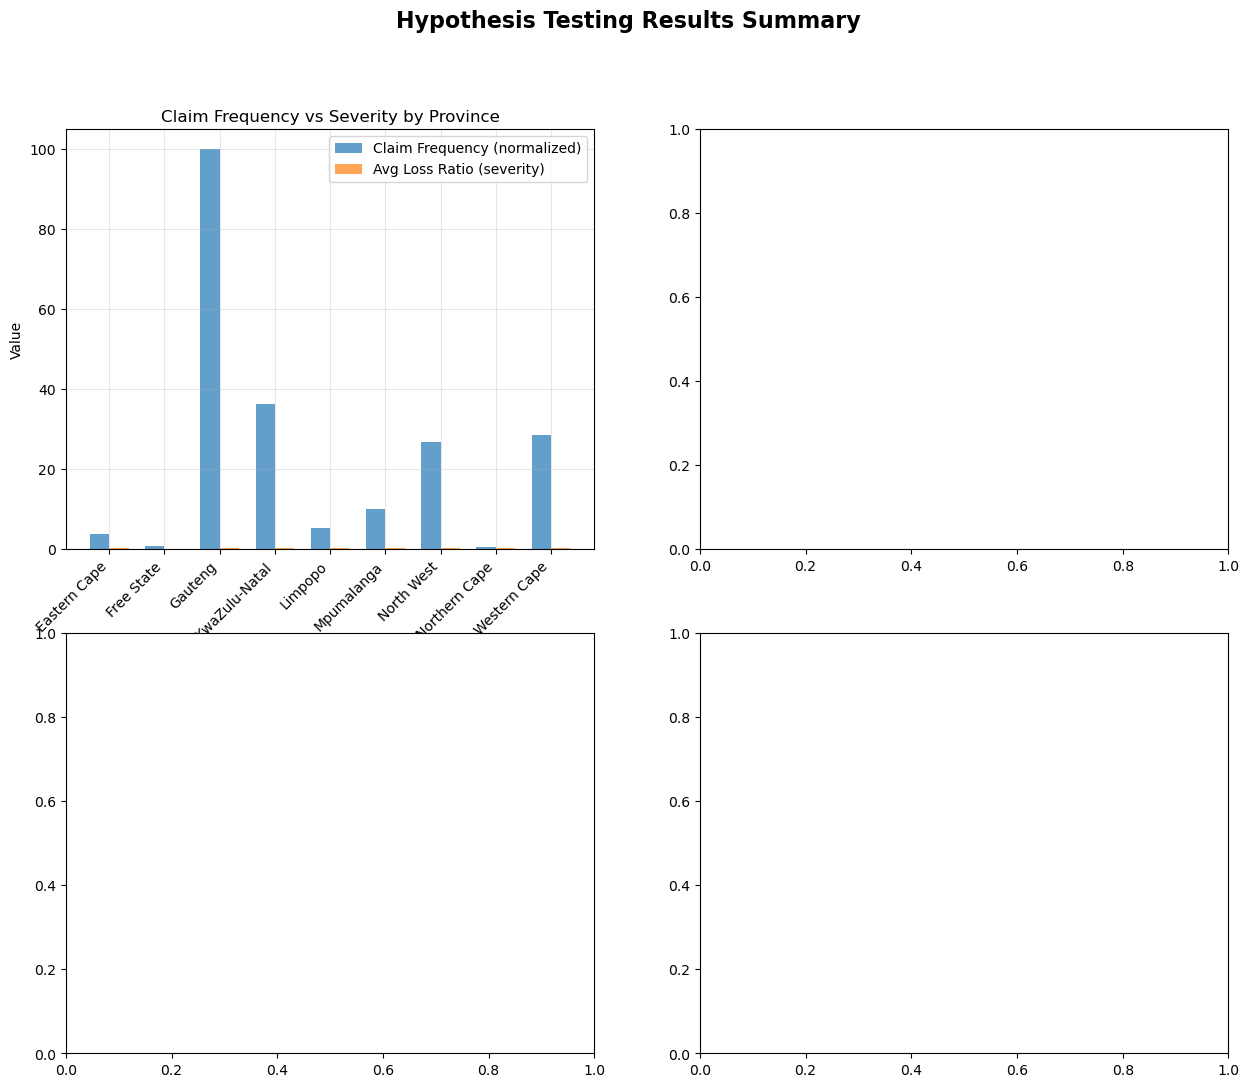

In [12]:
# Cell 14: Summary Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Hypothesis Testing Results Summary', fontsize=16, fontweight='bold')

# Plot 1: Claim Frequency vs Severity by Province
ax1 = axes[0, 0]
province_claim_stats = df_valid.groupby('Province').agg({
    'TotalClaims': lambda x: (x > 0).sum(),  # Claim frequency
    'LossRatio': 'mean'  # Claim severity (for policies with claims)
}).rename(columns={'TotalClaims': 'ClaimCount', 'LossRatio': 'AvgLossRatio'})

# Filter to only provinces with claims
province_claim_stats = province_claim_stats[province_claim_stats['ClaimCount'] > 0]

# Normalize claim count for scaling
province_claim_stats['ClaimCountNorm'] = province_claim_stats['ClaimCount'] / province_claim_stats['ClaimCount'].max() * 100

x = range(len(province_claim_stats))
width = 0.35

bars1 = ax1.bar([i - width/2 for i in x], province_claim_stats['ClaimCountNorm'], width, label='Claim Frequency (normalized)', alpha=0.7)
bars2 = ax1.bar([i + width/2 for i in x], province_claim_stats['AvgLossRatio'], width, label='Avg Loss Ratio (severity)', alpha=0.7)

ax1.set_xlabel('Province')
ax1.set_ylabel('Value')
ax1.set_title('Claim Frequency vs Severity by Province')
ax1.set_xticks(x)
ax1.set_xticklabels(province_claim_stats.index, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Top 10 Highest-Risk Zipcodes
ax2 = axes[0, 1]
# Get top 10 zipcodes by median LossRatio (with sufficient claims)
zip_risk = df_claims.groupby('PostalCode')['LossRatio'].agg(['median', 'count']).round(2)
zip_risk = zip_risk[zip_risk['count'] >= 10].sort_values('median', ascending=False).head(10)

bars = ax2.bar(range(len(zip_risk)), zip_risk['median'])
ax2.set_xlabel('Zipcode')
ax2.set_ylabel('Median Loss Ratio')
ax2.set_title('Top 10 Highest-Risk Zipcodes (min 10 claims)')
ax2.set_xticks(range(len(zip_risk)))
ax2.set_xticklabels(zip_risk.index, rotation=45, ha='right')
ax2.axhline(y=1, color='red', linestyle='--', label='Break-even')
ax2.legend()

# Add value labels
for i, (zipcode, row) in enumerate(zip_risk.iterrows()):
    ax2.text(i, row['median'] + 1, f"{row['median']:.0f}", ha='center', fontweight='bold')

# Plot 3: Profit Margin Distribution by Province
ax3 = axes[1, 0]
# Calculate profit margin for policies with claims
df_claims['ProfitMargin'] = 1 - df_claims['LossRatio']
province_profit = df_claims.groupby('Province')['ProfitMargin'].median().sort_values()

# Filter for provinces with enough claims
province_counts = df_claims.groupby('Province').size()
province_profit = province_profit[province_counts >= 10]

bars = ax3.barh(range(len(province_profit)), province_profit.values)
ax3.set_xlabel('Median Profit Margin (1 - LossRatio)')
ax3.set_ylabel('Province')
ax3.set_title('Profit Margin by Province (policies with claims)')
ax3.set_yticks(range(len(province_profit)))
ax3.set_yticklabels(province_profit.index)
ax3.axvline(x=0, color='red', linestyle='--', label='Break-even')

# Color bars: green for profit, red for loss
for i, bar in enumerate(bars):
    if province_profit.iloc[i] > 0:
        bar.set_color('green')
        bar.set_alpha(0.7)
    else:
        bar.set_color('red')
        bar.set_alpha(0.7)

# Plot 4: Gender Comparison (if data available)
ax4 = axes[1, 1]
try:
    # Try to get gender data if available
    if 'Gender_std' in df_claims.columns:
        gender_data = df_claims[df_claims['Gender_std'].isin(['Male', 'Female'])].copy()
        if len(gender_data) > 0:
            gender_stats = gender_data.groupby('Gender_std')['LossRatio'].agg(['median', 'count']).round(2)
            
            bars = ax4.bar(gender_stats.index, gender_stats['median'])
            ax4.set_xlabel('Gender')
            ax4.set_ylabel('Median Loss Ratio')
            ax4.set_title('Risk Comparison by Gender (policies with claims)')
            ax4.axhline(y=1, color='red', linestyle='--', label='Break-even')
            
            # Add count labels
            for i, (gender, row) in enumerate(gender_stats.iterrows()):
                ax4.text(i, row['median'] + 2, f"n={row['count']}", ha='center')
        else:
            ax4.text(0.5, 0.5, 'Insufficient gender data\nfor claims analysis', 
                    ha='center', va='center', transform=ax4.transAxes, fontsize=12)
    else:
        ax4.text(0.5, 0.5, 'Gender data not available\nfor claims analysis', 
                ha='center', va='center', transform=ax4.transAxes, fontsize=12)
except:
    ax4.text(0.5, 0.5, 'Error loading gender data', 
            ha='center', va='center', transform=ax4.transAxes, fontsize=12)

plt.tight_layout()
plt.savefig('../reports/hypothesis_testing_summary.png', dpi=150, bbox_inches='tight')
plt.show()

print("Summary visualizations saved to: reports/hypothesis_testing_summary.png")